In [1]:
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

import astropy

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst
%matplotlib inline
from matplotlib import pyplot as plt
import pipeline
from photutils import centroid_com
from astropy import units as u
from astropy import constants as const
import pandas as pd
import math as m
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from astropy import constants as const
from astropy.stats import sigma_clip
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter


from astropy.visualization import quantity_support
quantity_support() #not sure about this line but stackoverflow...try w/o it later

from matplotlib import pyplot as plt

In [2]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract2D(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

   #defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

In [3]:
#Finding all data file for specific target and doing instrumentation noise subtraction
flatid = 'DomeFlat'
atlasfiles_red = fits.open('henear.fits') #NOAO atlas  #RED side 
atlasfiles_blue = fits.open('fear.fits') #NOAO atlas #BLUE side 
linelist_red = reduce_dblspec.HENEAR_LINE_LIST #RED side
linelist_blue = reduce_dblspec.FEAR_LINE_LIST #BLUE side

############### possible changes to change targets
##################################################
arcfiles_red10 = 'DoubleSpec/20170519/red0012.fits' #henear ARC lamp #1.0" slit #RED side
arcfiles_blue10 = 'DoubleSpec/20170519/blue0012.fits' #fear ARC lamp #1.0" slit #BLUE side
targetID = '62224092496776-Odyssey'
all_side_files_red = 'DoubleSpec/20170519/red*.fits'#RED side
all_side_files_blue = 'DoubleSpec/20170519/blue*.fits'#BLUE side
target = fits.open('DoubleSpec/20170519/red0104.fits') #use these to get targetid
target[0].header
##################################################

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4141 / length of data axis 1                          
NAXIS2  =                  440 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
OBJECT  = '62224092496776-Od

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


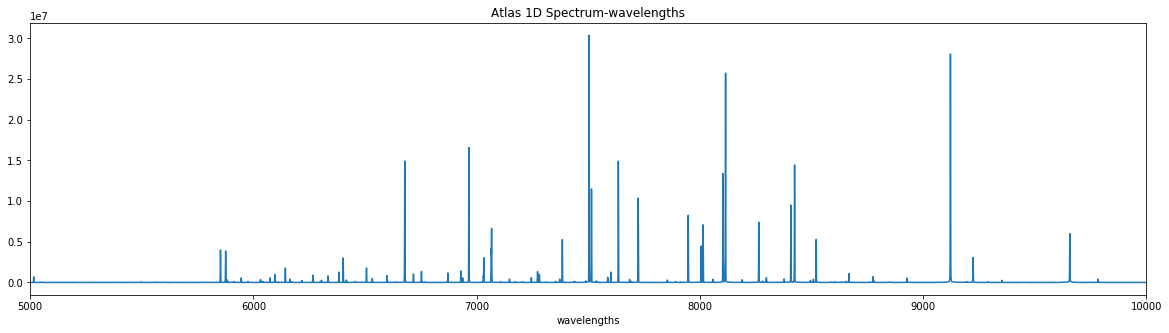

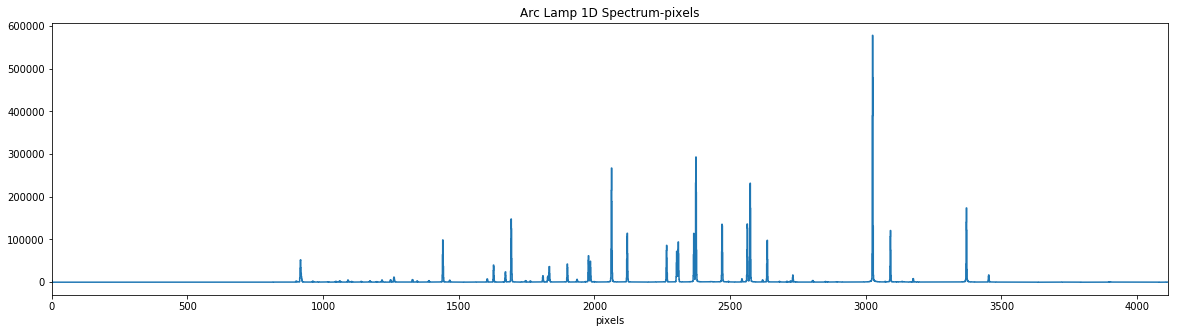

In [4]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_red = pipeline.dispersion(all_side_files_red, atlasfiles_red, arcfiles_red10, linelist_red,flatid)

/Users/dee/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


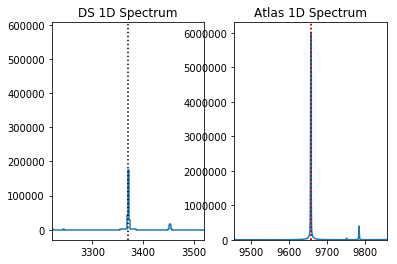

In [5]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(3370,9657,specset_red) #(arc-PIX-guess, atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [3024,2373,2062,1672,3370]
atlas_lines = [9122.9674,8115.311,7635.106,7032.4131,9657.7863]
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Failed to find line ArI at wl=7272.9359: "Guessed line's peak to base ratio is 5.524444256117296, which is less than 10"
Failed to find line HeI at wl=7281.349: "Guessed line's peak to base ratio is 7.032109457162515, which is less than 10"
Failed to find line ArI at wl=7353.293: "Guessed line's peak to base ratio is 1.658465011234017, which is less than 10"
Failed to find line ArI at wl=7372.1184: "Guessed line's peak to base ratio is 1.8965815375008566, which is less than 10"
Found line ArI at wl=7383.9805
Clipped 0 lines
Failed to find line NeI at wl=7488.8712: "Guessed line's peak to base ratio is 2.54705220294689, which is less than 10"
Found line ArI at wl=7503.8691
Clipped 0 lines
Found line ArI at wl=7514.6518
Clipped 0 lines
Failed to find line NeI at wl=7535.7739: "Guessed line's peak to base ratio is 2.2797688226410067, which is less than 10"
Failed to find line NeI at wl=7544.0443: "Guessed line's peak to base ratio is 1.4990809349450942, which is less than 10"
Failed to fi

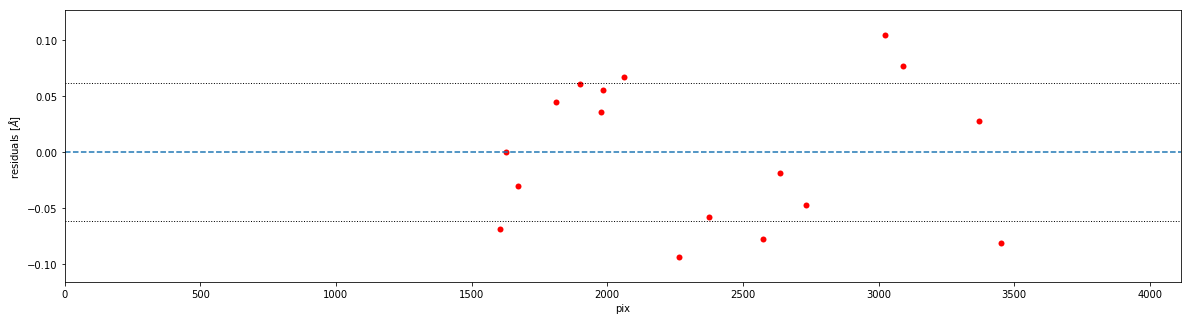

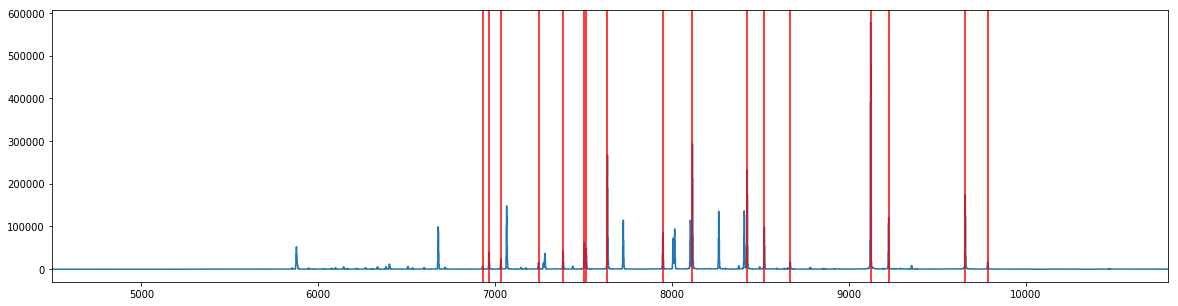

In [6]:
#creating a ds _ part three

ds_red = pipeline.goodness_of_matches(arcfiles_red10, guesses, all_side_files_red, atlasfiles_red, linelist_red, flatid);
#this is the final red side ds

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Blue side


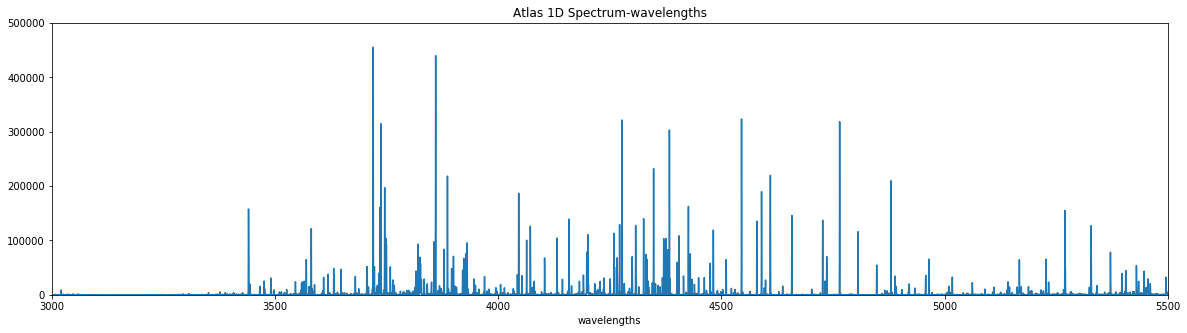

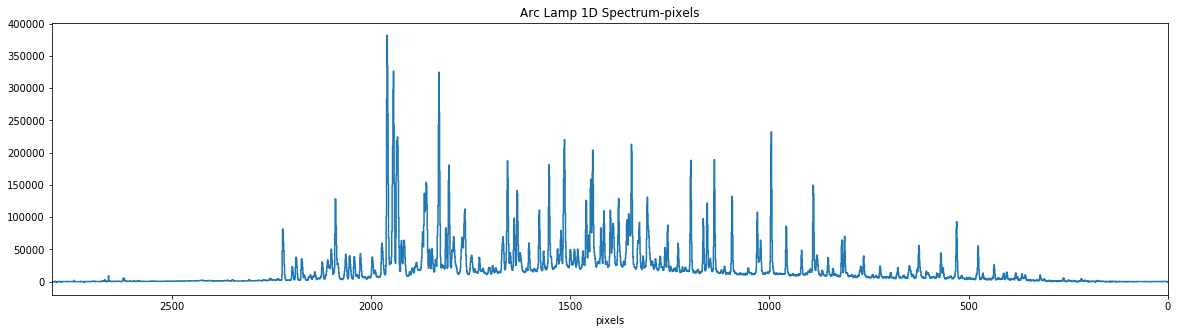

In [7]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_blue = pipeline.dispersion(all_side_files_blue, atlasfiles_blue, arcfiles_blue10, linelist_blue,flatid)

/Users/dee/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


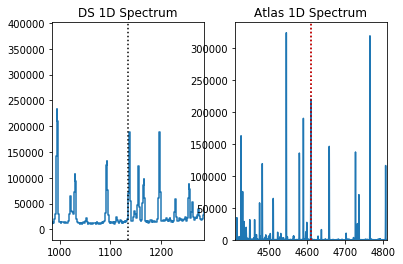

In [8]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(1135,4609,specset_blue) #(arc-PIX-guess,atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [1956,1827,993,1029,528]#badvals 1135
atlas_lines = [3719.9346, 3859.9114, 4764.8646, 4726.8683, 5269.5366] #badvals 4609.5673
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

In [9]:
#creating a ds _ part three------except blue side ds sucks

#ds_blue = pipeline.goodness_of_matches(arcfiles_blue10, guesses, all_side_files_blue, atlasfiles_blue, linelist_blue, flatid);
#this is the final blue side ds 

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


4 target files located
choose 2D spec for redside
choose 1D target spec axis limits for redside


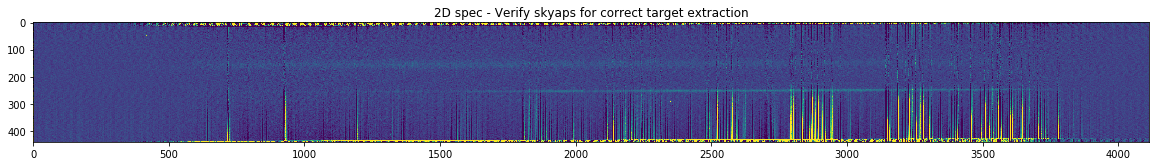

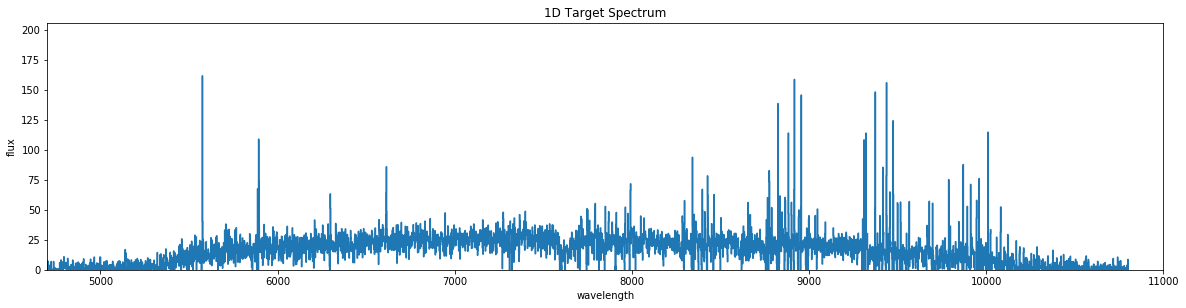

In [10]:
#RED side SPECTRUM

#define relevant pixel spatial regions
#####################################################
skyaps_red=[(77,135),(165,240)]#spatial regions above & below target to estimate sky emissions
model_red='linear' #estimating sky line tilt
specaps_red = (145,155)#(144,163)#WHAT IS THIS AGAIN? target spatial region? area btwn skyaps??
#####################################################

#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
target_flux_red, target_unc_red, target_comb_red = pipeline.sky_subtract(targetID, skyaps_red, ds_red, all_side_files_red, atlasfiles_red ,all_side_files_red, flatid, specaps_red, vmax, vmin, model_red)

In [11]:
#BLUE side SPECTRUM-----except blue side sucks

#define relevant pixel spatial regions
#####################################################
#skyaps_blue = [(130,190),(295,350)]#spatial regions above & below target to estimate sky emissions
#model_blue = 'linear'#('poly',2) #estimating sky line tilt
#specaps_blue = (271,306)#target spatial region
#####################################################
#helps color scale of 2D
#vmax = 40
#vmin = -10

#subtracts sky lines & stacks target images to extract 1D
#target_flux_blue, target_unc_blue, target_comb_blue = pipeline.sky_subtract(targetID, skyaps_blue, ds_blue, all_side_files_blue, atlasfiles_blue ,all_side_files_blue, flatid, specaps_blue, vmax, vmin, model_blue)

In [12]:
#isolates the sky-subtracted 2D spectrum

#choose best emission line side
##############################################
best_emission_comb = target_comb_red
best_emission_skyaps = skyaps_red
best_emission_model = model_red
##############################################

#sky-subtracting 2D
subimg2, comb2, fitmodels = sky_subtract2D(best_emission_comb, best_emission_skyaps, best_emission_model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

<Figure size 720x1800 with 0 Axes>

FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)
flux data shape: (38, 4104)
NOTE 10 spectral PIXELS missing  WL_PIX_CORRECTION DEFINED HERE!!!!!! 


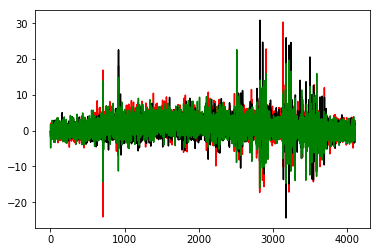

In [13]:
#PART ONE -----------------prep for centroiding

#first need to get target only 2D aka(1D spectrum for each spatial pixel row in the 2D target data)
############################################
#target_aperature=(143,171) #target location
target_aperature=(137,174) #target location

############################################
space_pix_correction = target_aperature[0]

flux_data=[] #to hold target only 2d spec
apslc = np.arange(target_aperature[0],target_aperature[1]+1,1) #list of rows to extract spec from
#np.shape(subimg2.data)#(440, 4114)


#extracting target spec from whole 2d spec
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects every row's spec within the target location
flux_data=np.array(flux_data)   
#need to find a way to sum over diff ranges of apslc 

#######################################################
#defining spectral correction factor (try to fit this into loop above later on)
wl_pix_correction = 10 #wont affect spatial pix values, only amount of flux but thats negligible
#######################################################

#just to visually confirm
plt.plot(flux_data[16],color='r')#near galaxy center
plt.plot(flux_data[5],color='k') #near galaxy edge
plt.plot(flux_data[25],color='g')#near opposite galaxy edge

#conclusions
print("FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)" )
print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE 10 spectral PIXELS missing ', 
      'WL_PIX_CORRECTION DEFINED HERE!!!!!! ')
#plt.ylim(-10,0) #def shows oversubtracting

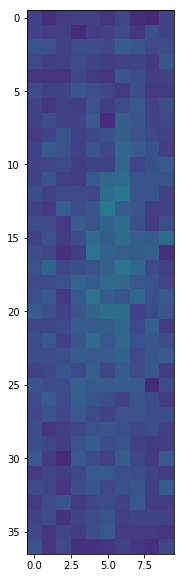

In [14]:
#PART TWO ----------------------determining best emission line pixel range

#using FULL ccd pixel range
################################################################
testingthis=subimg2.data[137:174,1394:1404] #[space,wl]for RED [wl,space]for BLUE
#conclusions
bestline_range_fullccd = (1394, 1404)
bestline_range_correction = (1384,1394) 
#################################################################

vmin=-10
vmax=45
plt.figure(figsize=(10,10))
plt.imshow(testingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels

Text(0.5,1,'h-alpha centroids in pixel values')

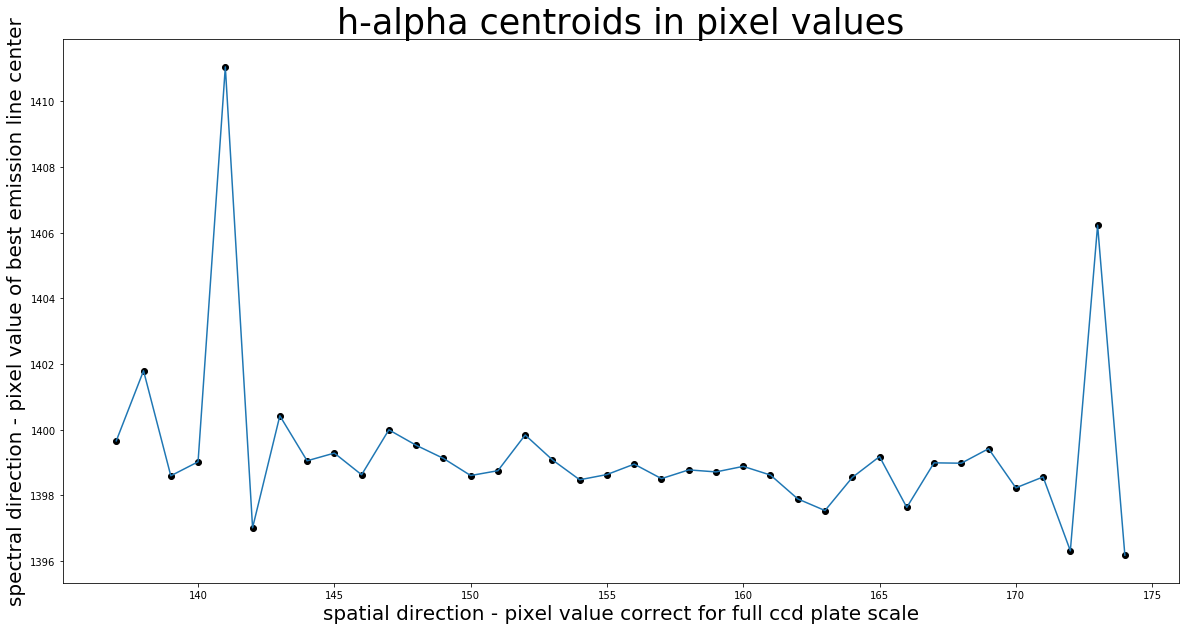

In [15]:
#PART THREE ------------------------------does the centroiding

#applies DS using full ccd pixel range 
#####################################################################
wl = np.array(ds_red.pixtowl(np.arange(len(subimg2.data[::][0]))))
#getting corresponding flux & wl values in best emission line region of 2D
wl_shorter2 = wl[1394:1404] #isolate wl around h-alpha using 'bestline_range_fullccd'
flux_data_short = flux_data[:,1384:1394] #use 'bestline_range_correction' range
#####################################################################


centroids_pix = []
mylist_ys2 = []
gfit_vals = []
stddev = []
means=[]
means_unc=[]




#gets halpha centroids/gaussians/uncertainities in target gal's range

for row in flux_data_short: 
    
    #calculates centroids per row
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    centroid_ys, centroid_xs = centroid_com(flux_fake2d2)#finds center(x,y) of best emission line for each row array
    mylist_ys2.append(centroid_ys)
    #print(centroid_xs, centroid_ys)
    centroids_pix.append(centroid_xs) #collects all best emission line centroids per row
    
    #calculating errors per row via gaussian fit
    x = ar(range(len(row)))
    y = row
    mean = centroid_xs
    g_init = models.Gaussian1D(amplitude=max(y), mean=mean, stddev=2.)
    fit_g = fitting.LevMarLSQFitter()
    gaussian = fit_g(g_init, x, y)
    gfit_vals.append(gaussian)
    stddev.append(gaussian.stddev.value)
    means.append(gaussian.mean.value)

    #trying to get uncertainities per row via covariance matrix
    gaussian.param_cov = fit_g.fit_info['param_cov']
    means_unc.append(fit_g.fit_info['param_cov'])#matrix fix
    #means_unc.append(fit_g.fit_info['param_cov'][1][1]) #if gives errors use matrix fix
    
    
#end of for loop  - making things into arrays so easier to work with  
centroids_pix = np.array(centroids_pix) #best emission line centroids (wl) array
gfit_vals = np.array(gfit_vals)  #all gaussian outputs in pixels
gauss_stddev = np.array(stddev) #std of gaussians in pixels
gaussian_means = np.array(means) #gaussian peaks in pixels


#converting pixel values to be wrt full cdd
#wl axis
centroid_specpix_fullccd = centroids_pix + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd = gaussian_means + stddev + wl_pix_correction + bestline_range_correction[0]
gaussmeans_specpix_fullccd = gaussian_means + wl_pix_correction + bestline_range_correction[0]
#space axis
target_spacepix_fullccd = np.arange(len(centroids_pix)) + space_pix_correction


 
    
#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,centroid_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.scatter(target_spacepix_fullccd,centroid_specpix_fullccd,c='k')
###########################################################
plt.title('h-alpha centroids in pixel values',fontsize=35)
###########################################################
#plt.xlim(143,171)
#plt.ylim(1396,1402)

Text(0.5,1,'h-alpha gaussians in pixel values')

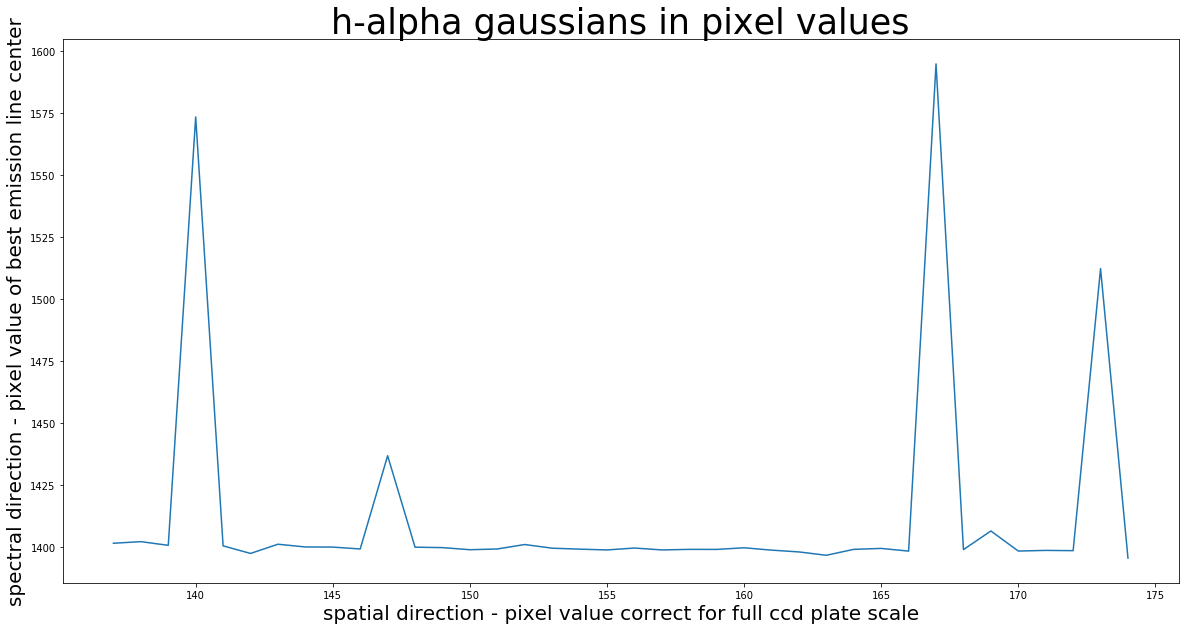

In [16]:
#gaussian means
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.title('h-alpha gaussians in pixel values',fontsize=35)

(1396, 1402)

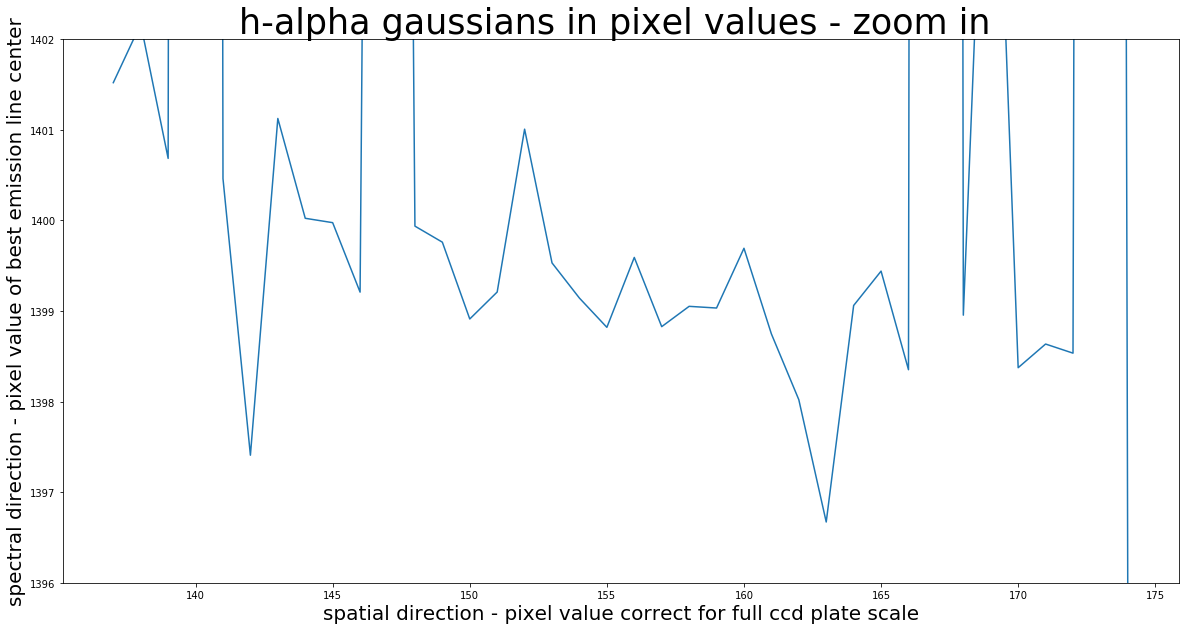

In [17]:
#zooming in 
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.title('h-alpha gaussians in pixel values - zoom in ',fontsize=35)
plt.ylim(1396,1402)

# removes bad fits

In [18]:
#collecting indicies of bad matrices


matrix = np.arange(0,len(means_unc),1)
print('these should be the same, if not explore:',len(matrix),len(gaussian_means))

badindices = []
for i in matrix:
    if np.any(means_unc[i]) == None:
        print('bad matrix at array:',i, means_unc[i])
        badindices.append(i)
    else:
        ok = 'ok'
print('number of bad fits is:',len(badindices))

these should be the same, if not explore: 38 38
bad matrix at array: 3 None
bad matrix at array: 8 None
bad matrix at array: 30 None
number of bad fits is: 3


In [19]:
#masking bad uncertaiinty values


evenmore_badindices=[]
masked_gsigs_means=[]
for i in  range(len(means_unc)):
    if type(means_unc[i]) == np.ndarray: #'NoneType':
        gmatrix_unc=means_unc[i][1][1]
    #b/c these are the good fits, keep those vals
    else:
        gmatrix_unc=np.nan
        evenmore_bad = i
        evenmore_badindices.append(evenmore_bad)
    masked_gsigs_means.append(gmatrix_unc)
evenmore_badindices = np.array(evenmore_badindices)
masked_gsigs_means = np.array(masked_gsigs_means)
print(evenmore_badindices,len(evenmore_badindices),badindices,'good they match, as they should')

[ 3  8 30] 3 [3, 8, 30] good they match, as they should


In [20]:
#masking bad gaussian values


more2_badindices=[]
more_badindices=[]
masked_gaussian_means=[]
for i in  range(len(gaussian_means)):
    #b/c bad fit produced no cov matrix
    if i in badindices:
        gaussian_means[i] = np.nan
    #b/c mean value shouldnt be outside this pixel range
    elif gaussian_means[i] <=0.0:
        gaussian_means[i]=np.nan
        more2_bads = i
        more2_badindices.append(more2_bads)
###############depends on width of h-alpha######################################
    elif gaussian_means[i] >=10.0:
###############################################################################
        gaussian_means[i] = np.nan
        more2_bads=i
        more2_badindices.append(more2_bads)
    #b/c these are the good fits, keep those vals
    else:
        gaussian_means[i]=gaussian_means[i]
    masked_gaussian_means.append(gaussian_means[i])
more2_badindices = np.array(more2_badindices)
masked_gaussian_means = np.array(masked_gaussian_means)

In [21]:
#collecting all bad fit indicies.....NOT in fullccd pix space, in target pix space


all_bad_idx = np.concatenate([more2_badindices,evenmore_badindices])
all_bad_idxs = np.sort(all_bad_idx)
all_bad_idxs
#more2_badindices, evenmore_badindices

array([ 3,  8, 10, 30, 32, 36])

In [22]:
# changing those (evenmore bad indicies) values to nan in the uncertainity array


fullmask_sigma=[]
for i in  range(len(masked_gsigs_means)):
    #b/c bad fit produced no cov matrix
    if i in more2_badindices:
        masked_gsigs_means[i] = np.nan
    #b/c these are the good fits, keep those vals
    else:
        masked_gsigs_means[i]=masked_gsigs_means[i]
    #print(i,masked_gsigs_means[i])
    fullmask_sigma.append(masked_gsigs_means[i])
fullmask_sigma = np.array(fullmask_sigma)

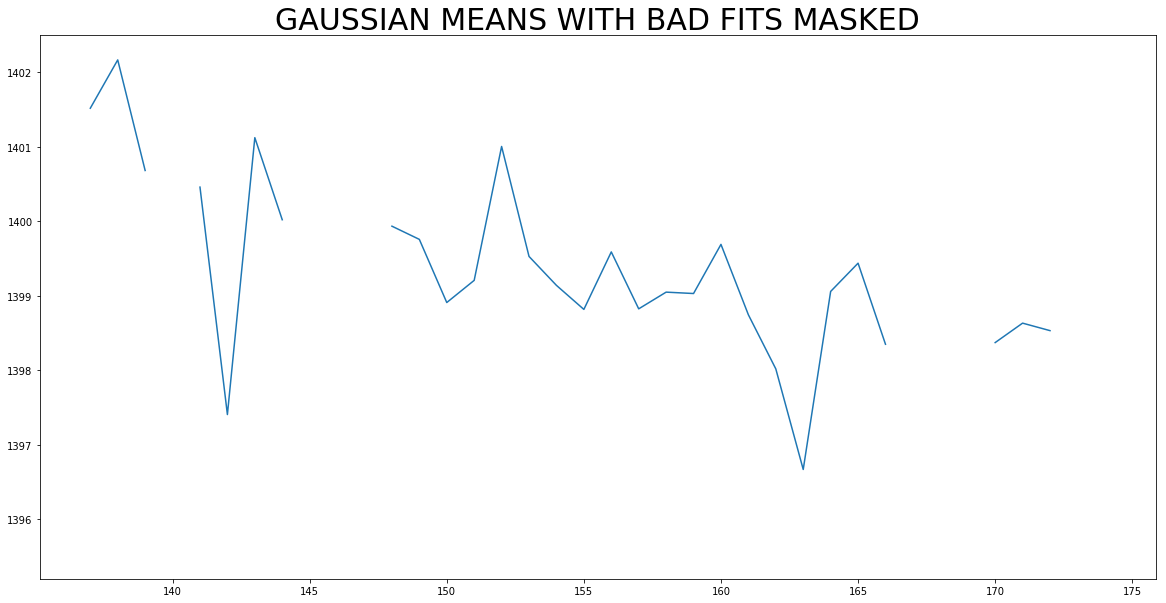

In [23]:
gaussmeans_specpix_fullccd_MASKED = masked_gaussian_means + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd_MASKED = masked_gaussian_means + stddev + wl_pix_correction + bestline_range_correction[0]


plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED)

(1394, 1404)

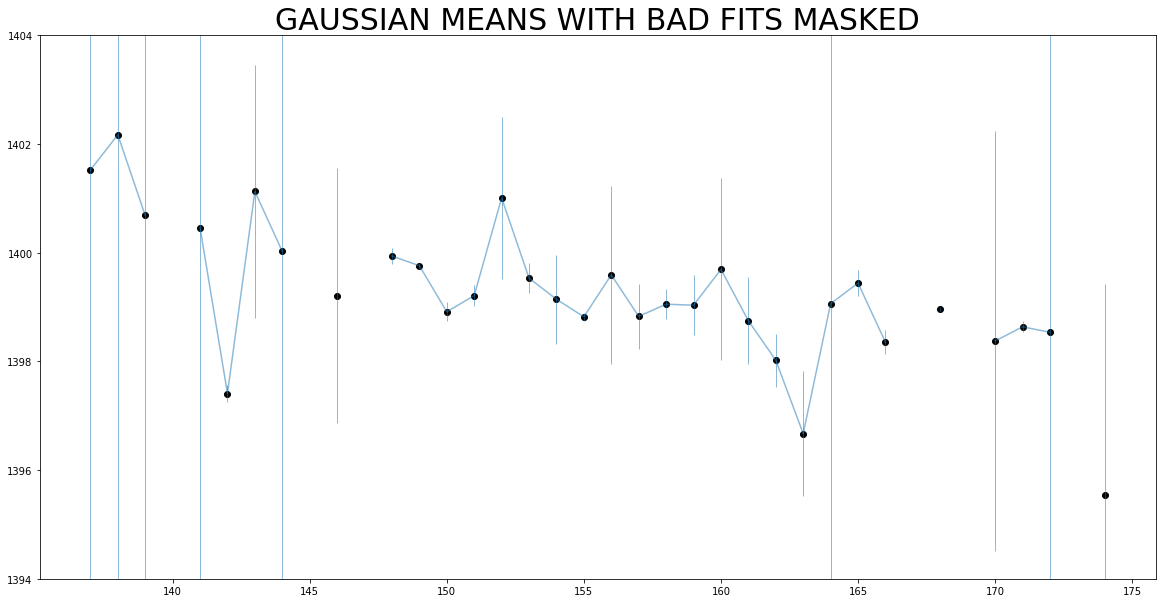

In [24]:
#with error bars


plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.scatter(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED,marker='o',c='k')
plt.errorbar(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED,yerr=fullmask_sigma,capsize=0,elinewidth=1,alpha=.5)

plt.ylim(1394,1404)

# apply ds

Text(0.5,1,'h-alpha gaussian means in wl values')

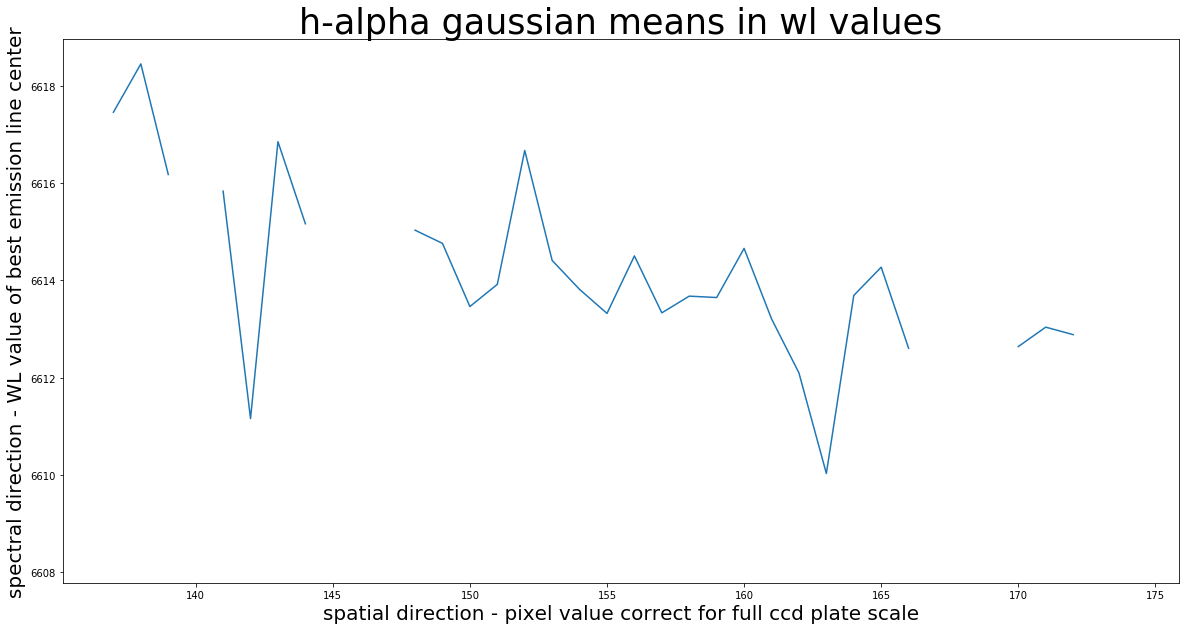

In [25]:
#applies ds


#gotta figure a way to keep masked values masked and not just add to a val from corrections
################################################################
wl_gaussians = np.array(ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED))
#################################################################

#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - WL value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,wl_gaussians)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
##########################################################
plt.title('h-alpha gaussian means in wl values',fontsize=35)
#plt.axvline(165)

# getting galaxy spectral core pix

In [26]:
#NOTE THAT THIS CELL USES GAUSSIAN VALUES.....IF CENTROIDS HAVE BETTER FIT (less likely) CHANGE IT

#robust way to clean data (to avoid bad g fits)
#################################################################
cleaned_gaussmeans = sigma_clip(masked_gaussian_means, sigma=3)
################################################################
avg_of_gmeans = np.mean(cleaned_gaussmeans)

#correcting avg Ha wl pixel value to reflect its place on the full ccd scale
bestline_corewl_pix_fullccd = avg_of_gmeans + wl_pix_correction + bestline_range_correction[0]
print('pix value of halpha core spectral axis is:',bestline_corewl_pix_fullccd)

#applying ds to get pix to wl value
########################################################################
bestline_core_wl = ds_red.pixtowl(bestline_corewl_pix_fullccd)*u.angstrom
#########################################################################

print('Best emission line "core" wl (based on gaussian fits) is:',bestline_core_wl)

pix value of halpha core spectral axis is: 1399.232458632058
Best emission line "core" wl (based on gaussian fits) is: 6613.955364332402 Angstrom


In [27]:
wl_gauss_test = ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED)*u.angstrom
wl_gaussians = np.array(ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED))
average = np.nanmean(wl_gauss_test)
#print(wl_gauss_test,'thank you next',wl_gaussians,'average of the averaged',average)
print(average)

6613.955380803034 Angstrom


# getting galaxy spatial core

(38, 4104)
1394 1384
shape of first section: (38, 50) matches shape of second section: (38, 50)
shape of first section 2d: (38, 1)
shape of second section 2d: (38, 1)
first section centroid y,x: 0.0 18.963248012875145
second section centroid y,x: 0.0 18.50594387337863
This is the average pixel value of the core BEFORE SPATIAL CORRECTIONS 18.734595943126887
Pixel Value of core along spatial axis wrt full CCD size 155.7345959431269


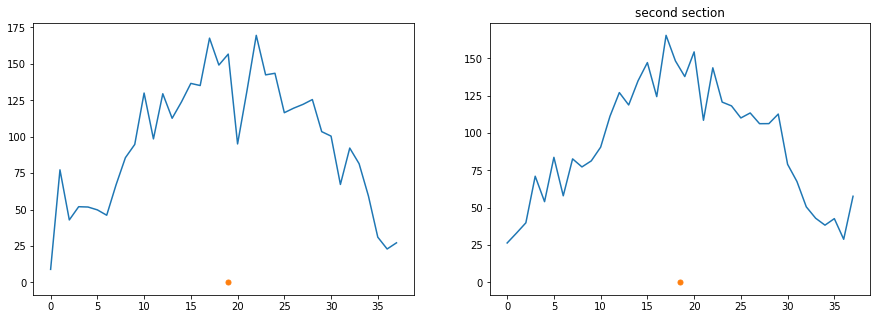

In [28]:
#USING SECTIONS SURROUNDING HALPHA WL RANGE
print(np.shape(flux_data))#(168,4104) #note that this is missing those wl's


#making arrays surrounding best emission line
################################################
upperha = bestline_range_correction[1]
lowerha = bestline_range_correction[0]
print(bestline_range_correction[1],bestline_range_correction[0])
#################################################
width_sections = 50 #reduced from 50 to 25 to avoid cosmic rays skewing to higher pix side
upper_one = lowerha - 1 #distance to avoid line emission contaminating core determination
lower_one = upper_one - width_sections
lower_two = upperha + 1 #giving it some distance
upper_two = lower_two + width_sections
first_section = flux_data[:,lower_one:upper_one]
second_section = flux_data[:,lower_two:upper_two]
print('shape of first section:', np.shape(first_section), 'matches shape of second section:', np.shape(second_section))


#collapsing both sections in the spatial direction (histogram like)
first_section_sum = np.sum(first_section,axis=1) 
first_section2d = first_section_sum[:,np.newaxis] #2d required to centroid
second_section_sum = np.sum(second_section,axis=1)
second_section2d = second_section_sum[:,np.newaxis] #2d required to centroid
print('shape of first section 2d:', np.shape(first_section2d))
print('shape of second section 2d:', np.shape(second_section2d))


#does the centroiding
y_first, x_first = centroid_com(first_section2d)
y_second, x_second = centroid_com(second_section2d)
print('first section centroid y,x:',x_first,y_first)
print('second section centroid y,x:',x_second,y_second)



#verify by plots
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(first_section2d);
ax2.plot(second_section2d);
#note below had to reverse xy centroids to visualize correctly, not sure why it inverted tho...
ax1.plot(y_first,x_first, '.', markersize=10)
ax2.plot(y_second,x_second, '.', markersize=10)
ax2.set_title('second section')
#averaging the two core values, the y's
core_array = np.array([y_first,y_second])
core_avgcentroids = np.mean(core_array)
print('This is the average pixel value of the core BEFORE SPATIAL CORRECTIONS',core_avgcentroids)

#FULL CCD pixel value of core
core_from_sections = core_avgcentroids + space_pix_correction #corrects for spatial axis target cutout
print('Pixel Value of core along spatial axis wrt full CCD size',core_from_sections)

# converting pix ----> kpc

In [29]:
distance_pix_wrtcore_sections = target_spacepix_fullccd - core_from_sections #for core wl using 2 sections around best emission line

In [30]:
#actual converting for loop CENTROIDS pixels to kpc
## good for core defined by 2 sections around halpha

#converts pixels to kpc (distance profile)
arcmins_sections =[]
distances_sections=[]
more_sections = []


#converts pix to kpc and saves as quantity list
for i in distance_pix_wrtcore_sections:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    blueplatescale = 0.389*u.arcsec/u.pixel
    dbsp_pix_equiv_red = u.pixel_scale(redplatescale)
    dbsp_pix_equiv_blue = u.pixel_scale(blueplatescale)
    r_in_pixel = i*u.pixel
    ################################################################
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv_red)
    distance = 34*u.Mpc # distance of object (host) from us
    ###############################################################
    rad_to_arcmin = (1*u.rad).to('arcmin')
    r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
    more_sections = r_in_kpc #/ (1*u.kpc)
    distances_sections.append(more_sections.value)
distances_sections = np.array(distances_sections)

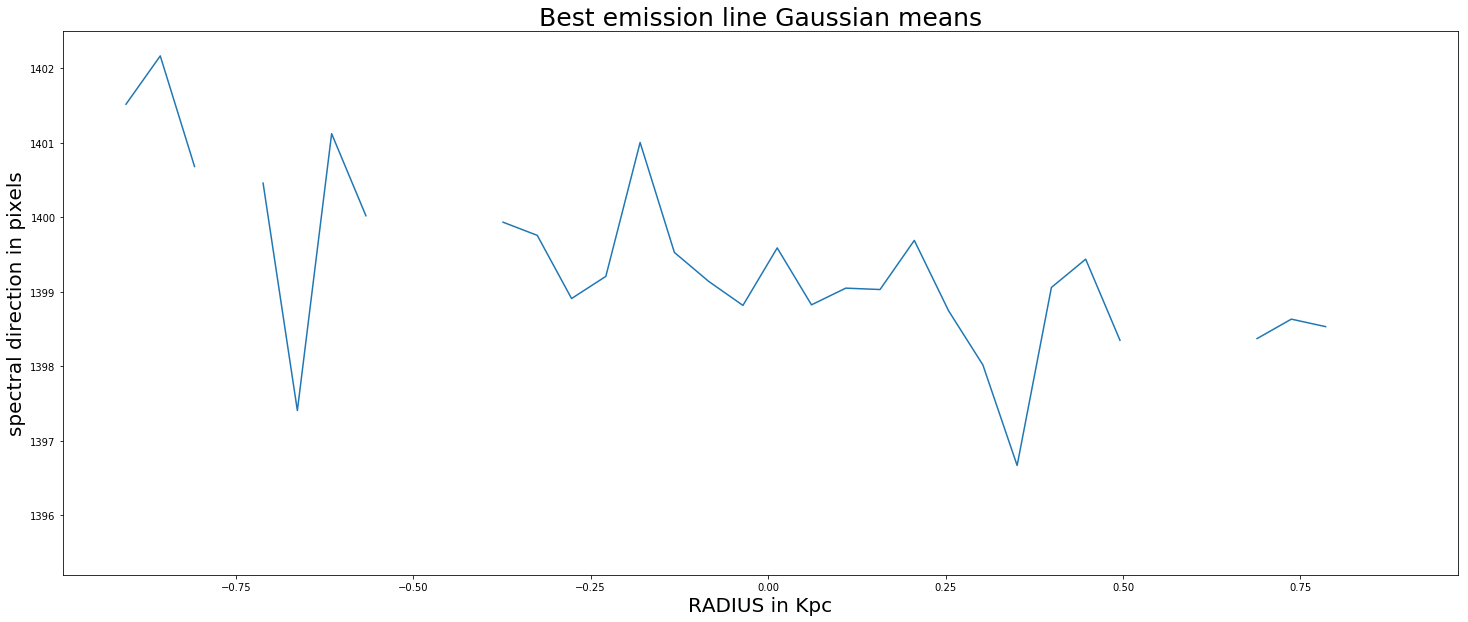

In [31]:
#GAUSSIAN MEANS plot with pix-wls & kpc

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)
plt.plot(distances_sections * u.kpc, gaussmeans_specpix_fullccd_MASKED)

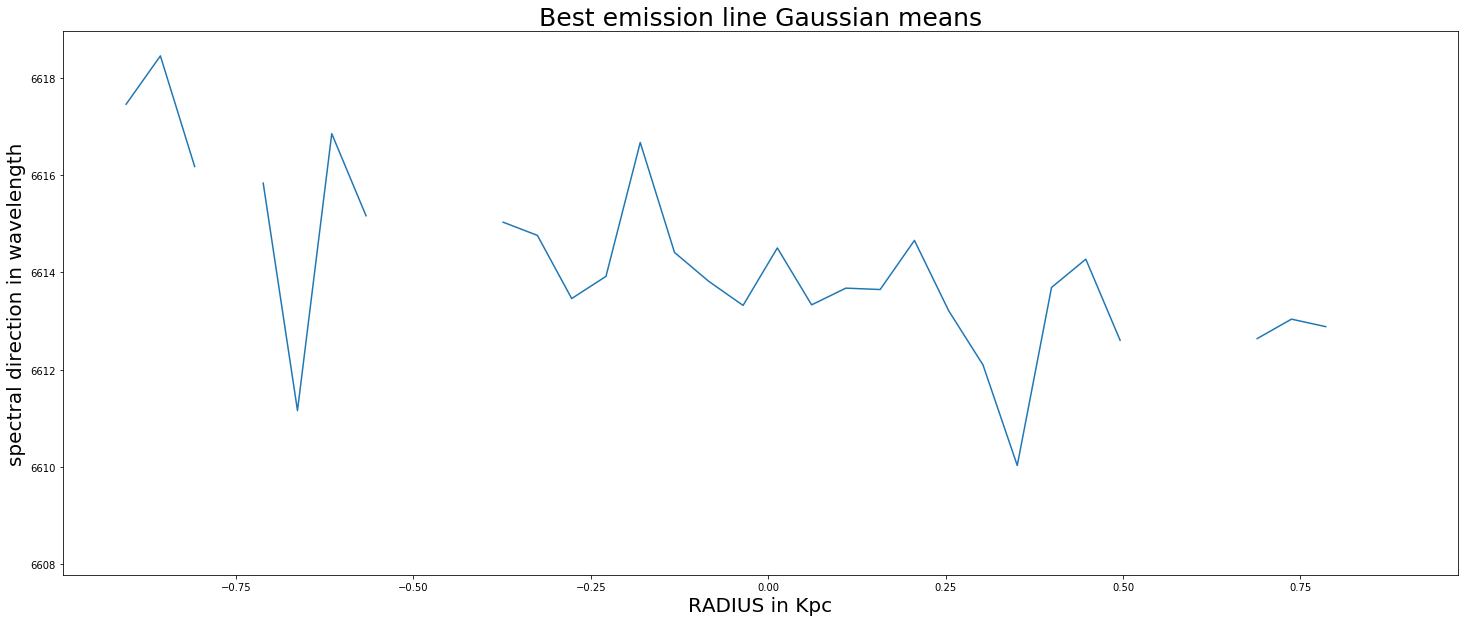

In [32]:
#GAUSSIAN MEANS plot with wl & kpc

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in wavelength',fontsize=20)
plt.plot(distances_sections * u.kpc, wl_gaussians)

# doesnt rely on spatial core

In [33]:
### doesnt rely on distance from core



distances_sections_target=[]
more_sections_target = []

#converts pix to kpc and saves as quantity list
for i in target_spacepix_fullccd:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    blueplatescale = 0.389*u.arcsec/u.pixel
    dbsp_pix_equiv_red = u.pixel_scale(redplatescale)
    dbsp_pix_equiv_blue = u.pixel_scale(blueplatescale)
    r_in_pixel = i*u.pixel
    ################################################################
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv_red)
    distance = 34*u.Mpc # distance of object (host) from us
    ###############################################################
    rad_to_arcmin = (1*u.rad).to('arcmin')
    r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
    more_sections_target = r_in_kpc #/ (1*u.kpc)
    distances_sections_target.append(more_sections_target.value)
distances_sections_target = np.array(distances_sections_target)

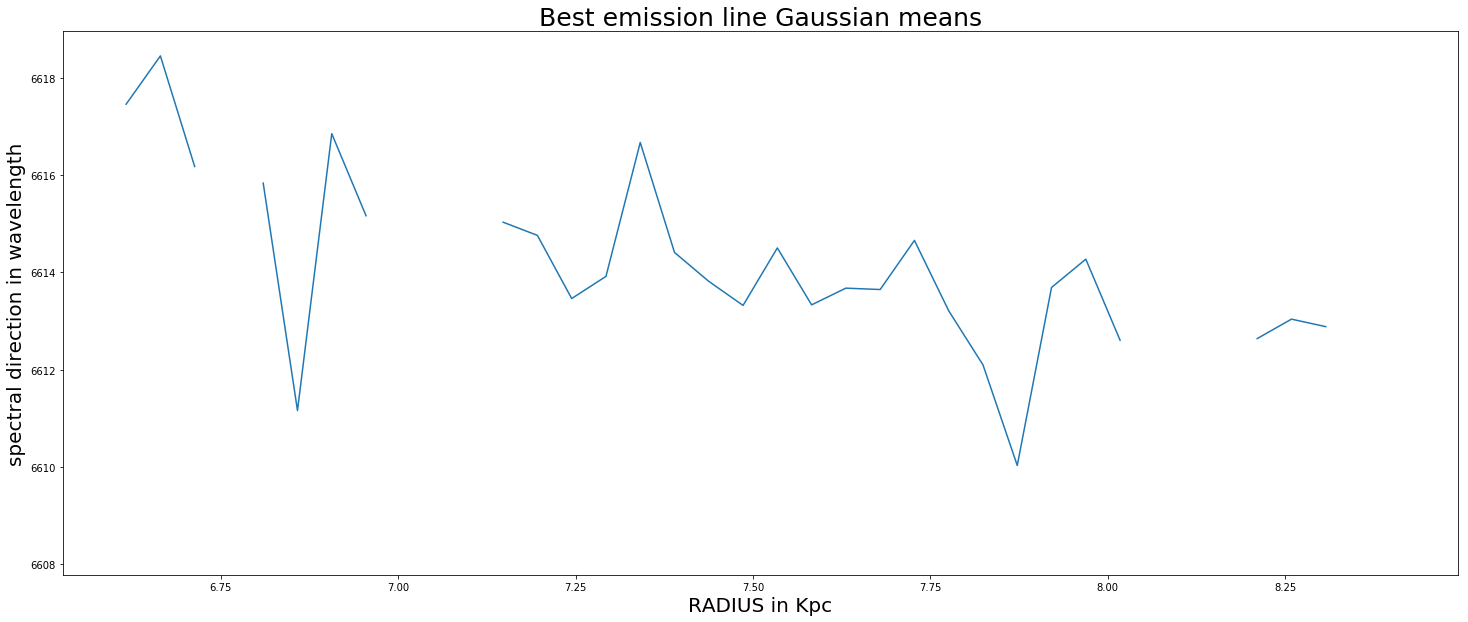

In [34]:
#GAUSSIAN MEANS plot with wl & kpc.....NO SPATIAL CORE from sections used

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in wavelength',fontsize=20)
plt.plot(distances_sections_target * u.kpc, wl_gaussians)

# converting pix--->wl---->velocity

In [35]:
#convert pix to wl via ds
###################################################################
#centroids_wl = ds_red10.pixtowl(centroid_specpix_fullccd)*u.angstrom
gauss_meanWstd_wl  = ds_red.pixtowl(gaussmax_specpix_fullccd_MASKED)*u.angstrom
gauss_means_wl = ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED)*u.angstrom
#core_wl_sections = ds_red.pixtowl(core_from_sections)*u.angstrom
####################################################################

In [36]:
#using redshift formula to get velocity

#((obs_wl - true_wl)/true_wl)* c = velocity
#except what we want is  v_not relative to core - v_of core

#velocities NOT yet relative to the core
##############################################################################
v_spec_gaussians = ((gauss_means_wl/(6563*u.angstrom)) -1) * const.c #gaussian velocities
#v_spec_centroids = (centroids_wl /(6563*u.angstrom) -1) * const.c #centroid velocities
#v_core = ((bestline_core_wl/(6563*u.angstrom)) -1) * const.c #core velocity
v_core = ((average/(6563*u.angstrom)) -1) * const.c #core velocity
#v_core uses average val of gaussmeans_specpix_fullccd_MASKED passed into ds(so more like normalizing)
#average = np.nanmean(gauss_means_wl)
###############################################################################

#velocities relative to the core from sections
y_axis_Gvelocity = (v_spec_gaussians - v_core).to('km/s')  #gaussian
#y_axis_Cvelocity = (v_spec_centroids - v_core).to('km/s') #centroids

print("velocity of best emission line's spectral 'core':",v_core.to('km/s'), len(y_axis_Gvelocity),y_axis_Gvelocity)

velocity of best emission line's spectral 'core': 2327.600009030543 km / s 38 [ 160.19818868  205.62563651  101.67400652           nan   86.0459304
 -127.7355055   132.52964155   55.37629618           nan   -1.69239761
           nan   49.32333321   36.92077828  -22.44695589   -1.60651254
  124.25821756   20.88761116   -6.31231532  -28.9036202    25.12726754
  -28.37244032  -12.67671024  -13.97673643   32.20706004  -33.96980237
  -84.81810686 -179.35907511  -12.02328125   14.54305115  -61.65877524
           nan  -19.49279435           nan  -60.09336587  -41.81374288
  -48.86010881           nan -258.90477197] km / s


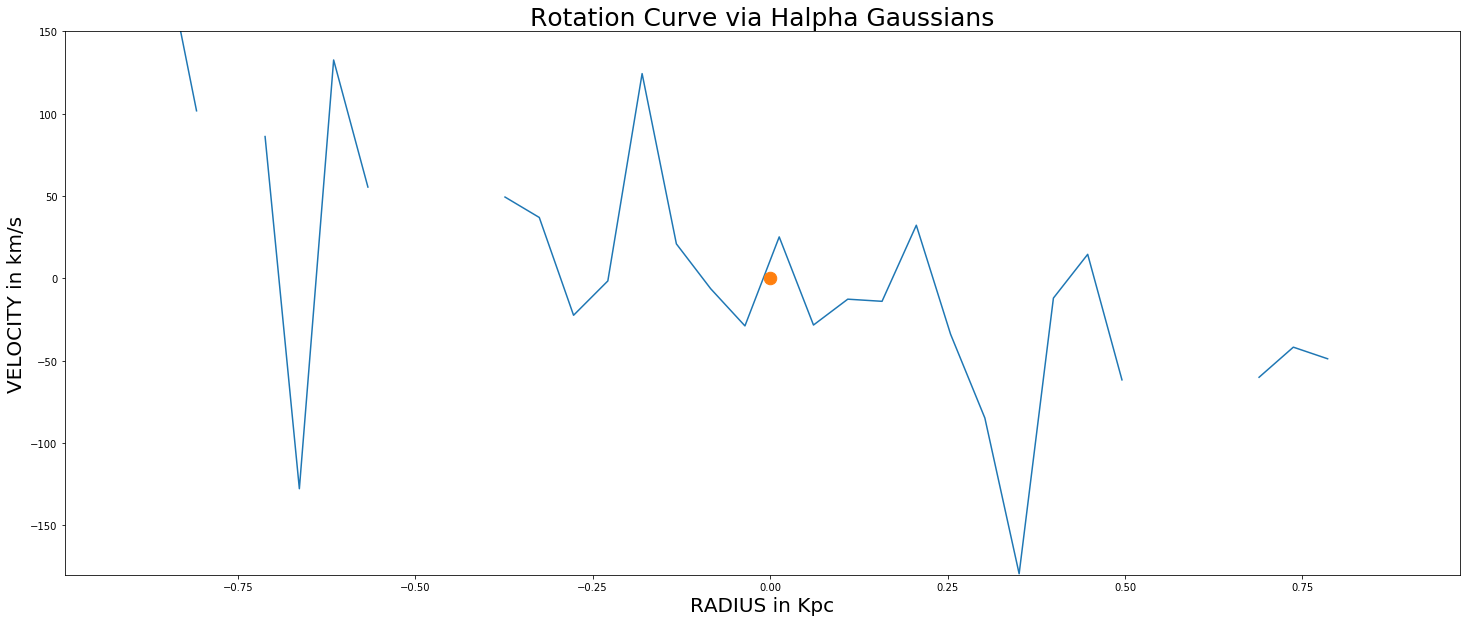

In [37]:
# used core from sections

plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.plot(distances_sections * u.kpc, y_axis_Gvelocity)
plt.ylim(-180,150) #adjust as needed to center around zero
plt.plot(0,0,'.', markersize=25)

# errorbars

In [38]:
#newer way trying to get core from eriks model

########################################### fullmask_sigma is in pixels
sigma_gauss_pix = np.sqrt(np.abs(fullmask_sigma)) #taking sqrt of unc to get a true sigma
################################################
#correct to full ccd pix scale
#print(sigma_gauss_pix)
means_Wsigma_fullccd = masked_gaussian_means + sigma_gauss_pix + wl_pix_correction + bestline_range_correction[0]
#apply ds
means_max_wl = ds_red.pixtowl(means_Wsigma_fullccd)*u.angstrom


#making into velocities
v_means_withsigma = (means_max_wl/ (6563*u.angstrom)-1) * const.c #be sure to check all values ok (no inf)
#in converting pix2wl2vel section...already did same steps for means w/o sigma


#extracting sigma velocity
v_unc = (v_means_withsigma - v_spec_gaussians).to('km/s') 
#print(np.shape(v_unc))
#np.reshape(v_unc,(226,))
print('v_unc', np.shape(v_unc))#make sure its same length as y_axis_Gvelocitys_unc

v_unc (38,)


In [39]:
dist_kpc = distances_sections * u.kpc

(-180, 150)

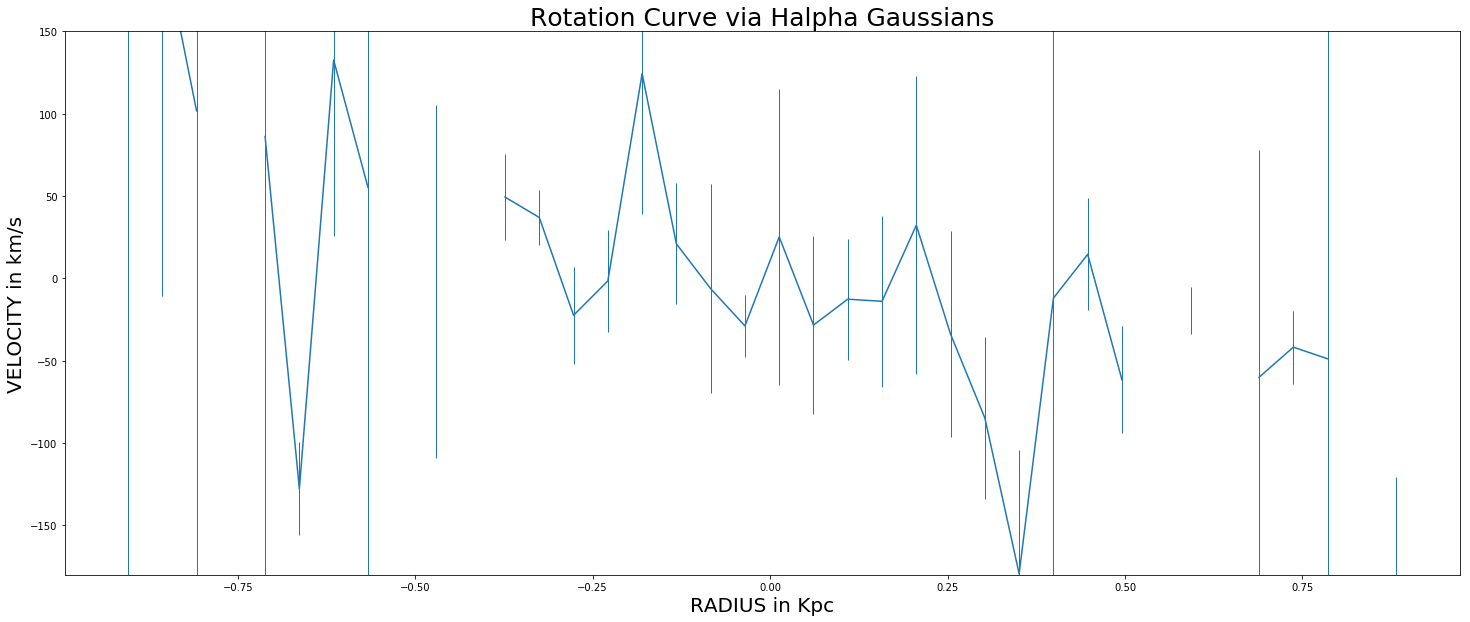

In [40]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.errorbar(np.asarray(dist_kpc), np.asarray(y_axis_Gvelocity),yerr=np.asarray(v_unc),elinewidth=1)
plt.ylim(-180,150) #adjust as needed to center around zero
#plt.plot(0,0,'.', markersize=25)

(-200, 200)

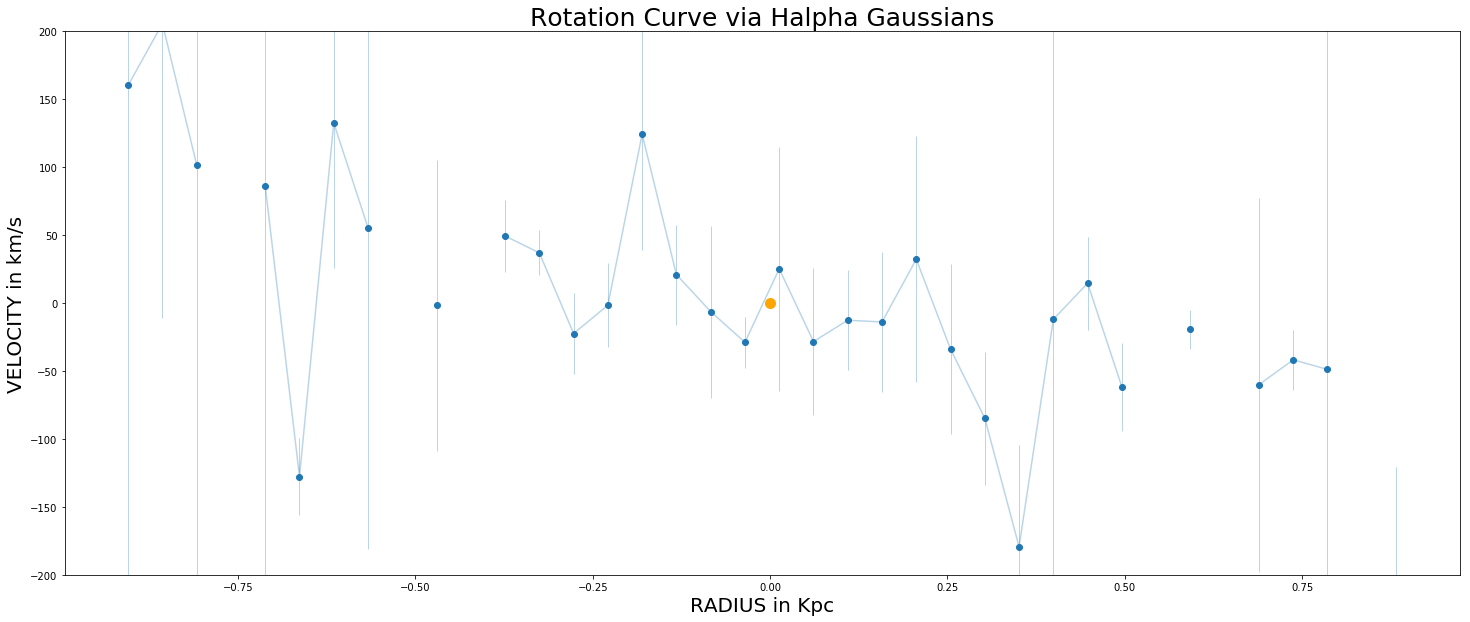

In [41]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.scatter(distances_sections * u.kpc, y_axis_Gvelocity)
plt.plot(0,0,'.', markersize=20,color='orange')
plt.errorbar(np.asarray(distances_sections * u.kpc), np.asarray(y_axis_Gvelocity),yerr=np.asarray(v_unc),elinewidth=1,alpha=0.3)
plt.ylim(-200,200) #adjust as needed to center around zero
#plt.plot(0,0,'.', markersize=25)

# mass modeling

In [42]:
arr=np.asarray

<eriksmodel(r_cen=0., alpha=678.72333589, beta=449.62609151, sigma=-1149.11975608, omega=0.48172514)>


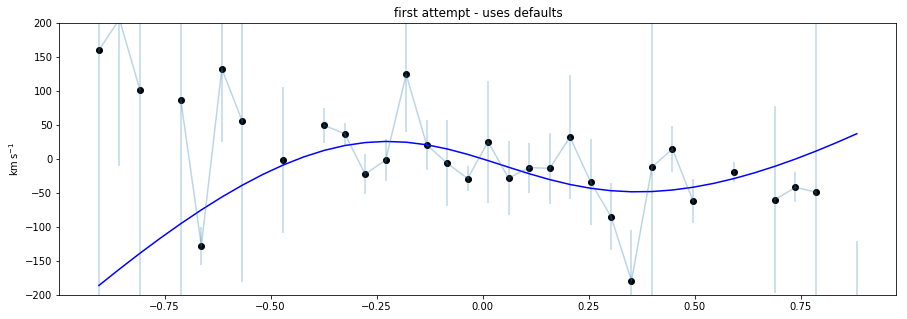

In [43]:
#uses core from sections
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r, r_cen=0, alpha=.00001, beta=.00001, sigma=-250, omega=.3):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)



#fit model to data
m_init = eriksmodel()
fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))

print(repr(m))

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections,y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections, m(distances_sections), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('first attempt - uses defaults');

<eriksmodel(r_cen=0., alpha=1., beta=1., sigma=-52.53359324, omega=0.15726596)>


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


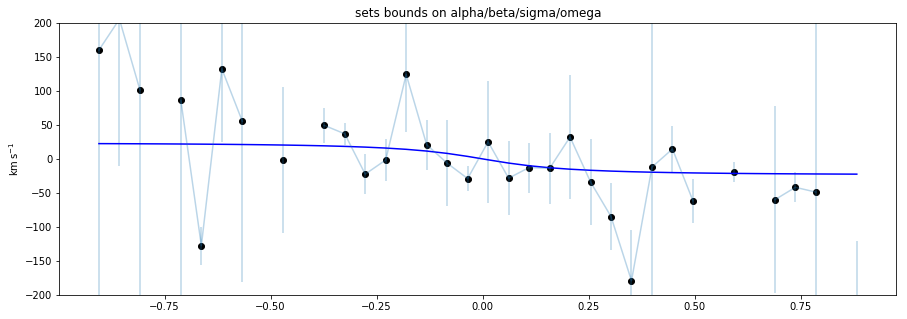

In [44]:
#uses core from sections & sets bounds
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r, r_cen=0, alpha=.000001, beta=.0000001, sigma=-250, omega=1):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)



#fit model to data
#m_init = eriksmodel()
m_init = eriksmodel(bounds={'alpha':(0.00000001,1), 'beta':(0.0000001,1),'sigma': (-300,300),'omega':(0,100)})

fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))

print(repr(m))

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections,y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections, m(distances_sections), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('sets bounds on alpha/beta/sigma/omega');

<eriksmodel(alpha=542.52832975, beta=390.9009826, sigma=-832.24635777, omega=0.36996102, v_offset=-8.53306667)>


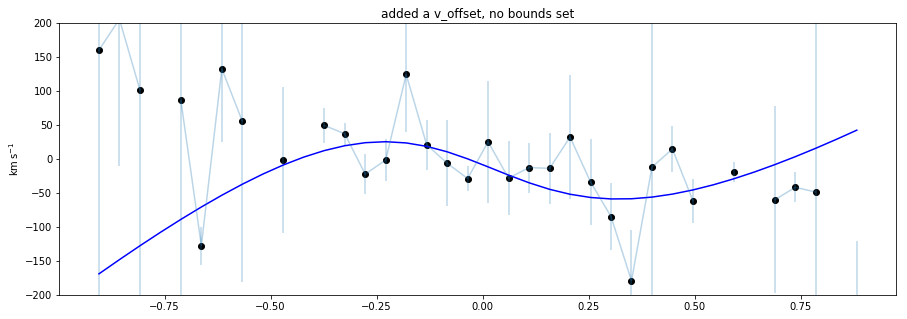

In [45]:
# added in a v-offset, no bounds

#uses core from sections
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r, alpha=.00001, beta=.00001, sigma=-250, omega=.3,v_offset=0):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)+v_offset


#fit model to data
m_init = eriksmodel()
fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))

print(repr(m))

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections,y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections, m(distances_sections), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('added a v_offset, no bounds set');
#print('WHY ARE ALPHA & BETA SOOOOOOO HIGH, LOOKS POLY LIKE ----FITS GET WORSE IF FORCE THEM TO BE LOW ')

<eriksmodel(alpha=1., beta=1., sigma=-45.54683401, omega=0.11244488, v_offset=-6.15948938)>
MAYBE THIS IS THE BEST BUT ALPHA/BETA STILL HIGH


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


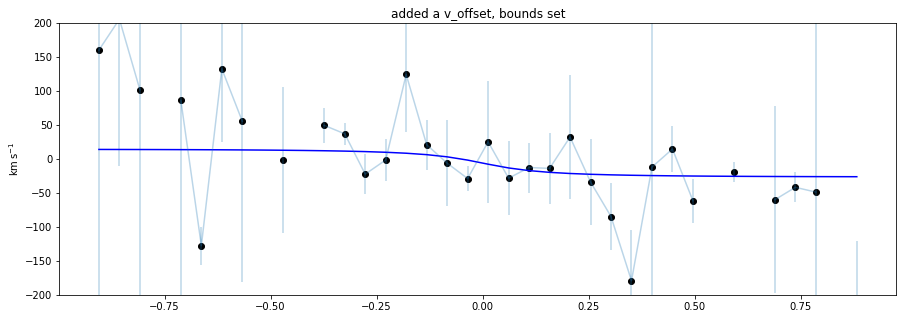

In [46]:
# added in a v-offset,  bounds set

#uses core from sections
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r, alpha=.00001, beta=.00001, sigma=-250, omega=1,v_offset=0):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)+v_offset


#fit model to data
m_init = eriksmodel(bounds={'alpha':(0.00000001,1), 'beta':(0.0000001,1),'sigma': (-300,300),'omega':(0,100)})
fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))

print(repr(m))

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections,y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections, m(distances_sections), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('added a v_offset, bounds set');
#print('WHY ARE ALPHA & BETA SOOOOOOO HIGH, LOOKS POLY LIKE ----FITS GET WORSE IF FORCE THEM TO BE LOW ')
print('MAYBE THIS IS THE BEST BUT ALPHA/BETA STILL HIGH')

<eriksmodel(r_cen=7.23009965, alpha=1., beta=1., sigma=-47.10156423, omega=0., v_offset=-0.26400465)>


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


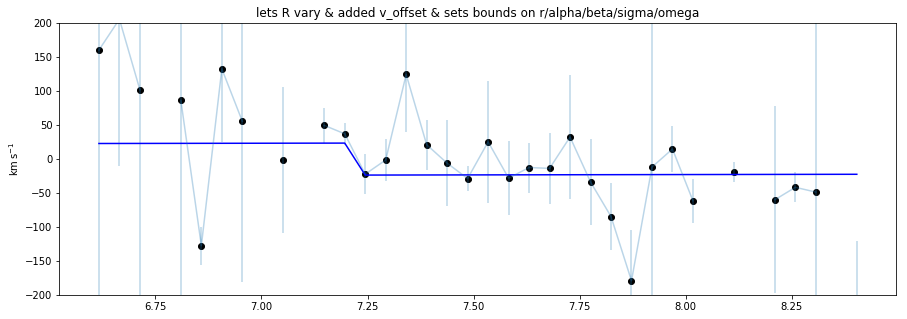

In [47]:
# added in a v-offset & dr b/c v-offset & BOUNDS ON ALPHA/BETA

#uses core from sections
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r,r_cen=0, alpha=.00001, beta=.00001, sigma=-250, omega=1,v_offset=0):
    dr = r-r_cen
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi)+v_offset

# setting bounds
m_init = eriksmodel(bounds={'r_cen': (6.75,8), 'alpha':(.0000001,1), 'beta':(.0000001,1),'sigma': (-300,300),'omega':(0,100)})
m_init.r_cen=7.6

#fit model to data
fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections_target)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))

print(repr(m))

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections_target,y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections_target, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections_target, m(distances_sections_target), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('lets R vary & added v_offset & sets bounds on r/alpha/beta/sigma/omega');

# 2D overlay

(120, 200)

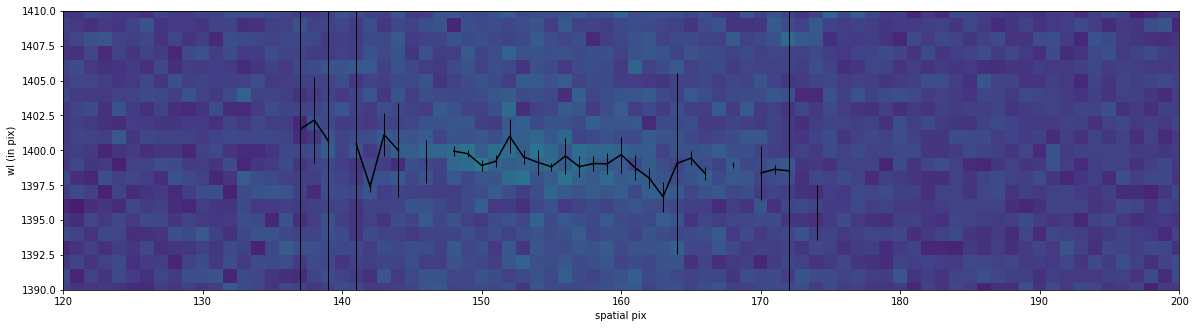

In [51]:
#in pixel space


y_unc_pixs = means_Wsigma_fullccd - gaussmeans_specpix_fullccd_MASKED #needed errors in pixs
subimg_fullccd =subimg2.data

vmin=-10
vmax=45
plt.figure(figsize=(20,10))#15,40
plt.imshow(subimg_fullccd.T,vmin=vmin,vmax=vmax)
plt.ylabel('wl (in pix)')
plt.xlabel('spatial pix')
plt.scatter(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED, marker='o',s=0.5,color='k')
plt.errorbar(target_spacepix_fullccd, gaussmeans_specpix_fullccd_MASKED, yerr=y_unc_pixs,elinewidth=1,color='k')
plt.ylabel('wl (in pix)')
plt.xlabel('spatial pix')
plt.ylim(1390,1410)
plt.xlim(120,200)#
#plt.xlim(80,275)#helps see overall flux on detector
#plt.ylim (1300,1450)#helps see continuum

# Binning

# ----------OLD BELOW THIS------------

In [49]:
throw an error

SyntaxError: invalid syntax (<ipython-input-49-976b416b5ec3>, line 1)

In [ ]:
# #matrix fix if needed above

# #takes out unc value from each matrix
# #exploring means_unc problem/solution


# print('10',type(means_unc[10]))

# #determining which index of matrix value i want
# print(np.shape(means_unc), 'MATRIX', means_unc[1],'SECOND ROW', means_unc[1][1], 'MIDDLE',means_unc[1][1][1])
# print('possible problem matrix here',means_unc[10])

# #setting up indexing array to explore all the matrices in for loop
# matrix = np.arange(0,len(means_unc),1)
# print('matrix length array', matrix)


# badmatrix = np.array([ 0.0, 0.0, 0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0])
# badmatrix = np.reshape(badmatrix,(3,3))
# print('shape',np.shape(badmatrix),'middle index',badmatrix[1][1])

# unc = []
# uncs = [] 
# badvalues = []  
    
# for i in matrix:
#     #np.array([means_unc])
#     #empty == type(np.any(means_unc[10])) #np.bool
#     #print('empty',empty)
#     if np.any(means_unc[i]) == None:
#         print('bad matrix at array:',i)
#         badvalues.append(i)
#         for j in badvalues:
#             means_unc[j] = badmatrix
#             ##uncs.append(means_unc[j][1][1])
#             #print('one replaced uncs',uncs)
#             #print('replaced with', means_unc[j])
#             #print('right index?', means_unc[j][1][1])
#             #print('replaced type',type(means_unc[j]))
#     else:
#         np.all(means_unc[i]) == np.all(means_unc[i])
#         #print('reg type',type(means_unc[i]),'i=',i) #np.ndarray
#     uncs.append(means_unc[i][1][1]) #does same as below
#     #print('one original uncs',uncs)
    
# unc.append(uncs) #does same as above
# print('unc',np.shape(unc),len(unc),'uncs',np.shape(uncs),len(uncs))
# print('uncs best b/c of shape but unc or uncs are both same array of middle term from matrices....ie sigma**2')
# #print('unc len',len(unc),'unc shape',np.shape(unc),'unc',unc)

# #print("another row", 'MATRIX', means_unc[51],'SECOND ROW', means_unc[51][1], 'MIDDLE',means_unc[51][1][1])
# #print('maybe uncs is best',uncs,'shape',np.shape(uncs),'length',len(uncs))

# print('use uncs for means_unc')


In [ ]:
# #converted centroids to wl to see how much of a shift there is

# #applies ds
# ################################################################
# wl_centroids = np.array(ds_red.pixtowl(centroid_specpix_fullccd))
# #################################################################

# #plotting
# plt.figure(figsize=(20,10))
# plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
# plt.ylabel('spectral direction - WL value of best emission line center',fontsize=20)
# plt.plot(target_spacepix_fullccd,wl_centroids)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
# ##########################################################
# plt.title('h-alpha centroids in wl values',fontsize=35)
# ##########################################################

In [ ]:
# #USING SECTIONS SURROUNDING HALPHA WL RANGE
# np.shape(flux_data)#(226,4104) #note that this is missing those wl's


# #making arrays surrounding best emission line
# ################################################
# upperha = 1404
# lowerha = 1394
# #################################################
# width_sections = 50 #reduced from 50 to 25 to avoid cosmic rays skewing to higher pix side
# upper_one = lowerha - 1 #distance to avoid line emission contaminating core determination
# lower_one = upper_one - width_sections
# lower_two = upperha + 1 #giving it some distance
# upper_two = lower_two + width_sections
# first_section = flux_data[:,lower_one:upper_one]
# second_section = flux_data[:,lower_two:upper_two]
# print('shape of first section:', np.shape(first_section), 'matches shape of second section:', np.shape(second_section))


# #collapsing both sections in the spatial direction (histogram like)
# first_section_sum = np.sum(first_section,axis=1) 
# first_section2d = first_section_sum[:,np.newaxis] #2d required to centroid
# second_section_sum = np.sum(second_section,axis=1)
# second_section2d = second_section_sum[:,np.newaxis] #2d required to centroid
# print('shape of first section 2d:', np.shape(first_section2d))
# print('shape of second section 2d:', np.shape(second_section2d))


# #does the centroiding
# x_first, y_first = centroid_com(first_section2d)
# x_second, y_second = centroid_com(second_section2d)
# print('first section centroid x,y:',x_first,y_first)
# print('second section centroid x,y:',x_second,y_second)



# #verify by plots
# f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
# ax1.plot(first_section2d);
# ax2.plot(second_section2d);
# #note below had to reverse xy centroids to visualize correctly, not sure why it inverted tho...
# ax1.plot(y_first,x_first, '.', markersize=10)
# ax2.plot(y_second,x_second, '.', markersize=10)

# #averaging the two core values, the y's
# core_array = np.array([y_first,y_second])
# core_avgcentroids = np.mean(core_array)
# print('This is the average pixel value of the core BEFORE SPATIAL CORRECTIONS',core_avgcentroids)

# #FULL CCD pixel value of core
# core_from_sections = core_avgcentroids + space_pix_correction #corrects for spatial axis target cutout
# print('Pixel Value of core along spatial axis wrt full CCD size',core_from_sections)

In [ ]:
# #NOTE THAT THIS CELL USES GAUSSIAN VALUES.....IF CENTROIDS HAVE BETTER FIT (less likely) CHANGE IT

# #robust way to clean data (to avoid bad g fits)
# #################################################################
# cleaned_gaussmeans = sigma_clip(gaussian_means, sigma=3)
# ################################################################
# avg_of_gmeans = np.mean(cleaned_gaussmeans)

# #correcting avg Ha wl pixel value to reflect its place on the full ccd scale
# bestline_corewl_pix_fullccd = avg_of_gmeans + wl_pix_correction + bestline_range_correction[0]
# print(bestline_corewl_pix_fullccd)

# #applying ds to get pix to wl value
# ########################################################################
# bestline_core_wl = ds_red.pixtowl(bestline_corewl_pix_fullccd)*u.angstrom
# #########################################################################

# print('Best emission line "core" wl (based on gaussian fits) is:',bestline_core_wl)

In [ ]:
# #centering around core first

# #still in pixel space
# distance_pix_wrtcore_sections = target_spacepix_fullccd - core_from_sections #for core wl using 2 sections around best emission line

In [ ]:
# #actual converting for loop CENTROIDS pixels to kpc
# #good for core defined by 2 sections around halpha

# #converts pixels to kpc (distance profile)
# arcmins_sections =[]
# distances_sections=[]
# more_sections = []


# #converts pix to kpc and saves as quantity list
# for i in distance_pix_wrtcore_sections:
#     r_in_arcmin = 1*u.arcmin
#     redplatescale = 0.293*u.arcsec/u.pixel
#     blueplatescale = 0.389*u.arcsec/u.pixel
#     dbsp_pix_equiv_red = u.pixel_scale(redplatescale)
#     dbsp_pix_equiv_blue = u.pixel_scale(blueplatescale)
#     r_in_pixel = i*u.pixel
#     ################################################################
#     r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv_red)
#     distance = 34.3*u.Mpc # distance of object (host) from us
#     ###############################################################
#     rad_to_arcmin = (1*u.rad).to('arcmin')
#     r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
#     more_sections = r_in_kpc #/ (1*u.kpc)
#     distances_sections.append(more_sections.value)
# distances_sections = np.array(distances_sections)

In [ ]:
# #CENTROID plot with pix-wls & kpc

# plt.figure(figsize=(25,10))
# plt.title('Best emission line Centroids', SIZE=25)
# plt.xlabel('RADIUS in Kpc',fontsize=20)
# plt.ylabel('spectral direction in pixels',fontsize=20)
# plt.plot(distances_sections * u.kpc, centroid_specpix_fullccd)

In [ ]:
# #GAUSSIAN MEANS plot with pix-wls & kpc

# plt.figure(figsize=(25,10))
# plt.title('Best emission line Gaussian means', SIZE=25)
# plt.xlabel('RADIUS in Kpc',fontsize=20)
# plt.ylabel('spectral direction in pixels',fontsize=20)
# plt.plot(distances_sections * u.kpc, gaussmeans_specpix_fullccd)
# plt.ylim(1390,1430)

In [ ]:
# #convert pix to wl via ds
# ###################################################################
# centroids_wl = ds_red.pixtowl(centroid_specpix_fullccd)*u.angstrom
# gauss_meanWstd_wl  = ds_red.pixtowl(gaussmax_specpix_fullccd)*u.angstrom
# gauss_means_wl = ds_red.pixtowl(gaussmeans_specpix_fullccd)*u.angstrom
# core_wl_sections = ds_red.pixtowl(core_from_sections)*u.angstrom
# ####################################################################

In [ ]:
#using redshift formula to get velocity

#((obs_wl - true_wl)/true_wl)* c = velocity
#except what we want is  v_not relative to core - v_of core

#velocities NOT yet relative to the core
##############################################################################
v_spec_gaussians = ((gauss_means_wl/(6563*u.angstrom)) -1) * const.c #gaussian velocities
v_spec_centroids = (centroids_wl /(6563*u.angstrom) -1) * const.c #centroid velocities
v_core = ((bestline_core_wl/(6563*u.angstrom)) -1) * const.c #core velocity
###############################################################################

#velocities relative to the core from sections
y_axis_Gvelocity = (v_spec_gaussians - v_core).to('km/s')  #gaussian
y_axis_Cvelocity = (v_spec_centroids - v_core).to('km/s') #centroids

print("velocity of best emission line's spectral 'core':",v_core)

In [ ]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.plot(distances_sections * u.kpc, y_axis_Gvelocity)
plt.ylim(-250,250) #adjust as needed to center around zero
plt.plot(0,0,'.', markersize=25)

In [ ]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Centroids', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.plot(distances_sections * u.kpc, y_axis_Cvelocity)
plt.ylim(-250,250) #adjust as needed to center around zero
plt.plot(0,0,'.', markersize=25)

In [ ]:
#using output from GAUSSIAN fit to determine error; tbd how to for CENTROIDS

#method to obtain sigma = subttract velocities of (mean+sigma) - mean = sigma 
sigma_gauss_pix = np.sqrt(np.abs(uncs)) #taking sqrt of unc to get a true sigma
#correct to full ccd pix scale
#print(sigma_gauss_pix)
means_Wsigma_fullccd = gaussian_means + sigma_gauss_pix + wl_pix_correction + bestline_range_correction[0]
#apply ds
means_max_wl = ds_red.pixtowl(means_Wsigma_fullccd)*u.angstrom


#making into velocities
v_means_withsigma = (means_max_wl/ (6563*u.angstrom)-1) * const.c #be sure to check all values ok (no inf)
#in converting pix2wl2vel section...already did same steps for means w/o sigma


#extracting sigma velocity
v_unc = (v_means_withsigma - v_spec_gaussians).to('km/s') 
#print(np.shape(v_unc))
#np.reshape(v_unc,(226,))
print('v_unc', np.shape(v_unc))#make sure its same length as y_axis_Gvelocity

In [ ]:
#rotation curve with gaussians with errorbars
plt.figure(figsize=(25,10))


arr = np.asarray #need to avoid setting array element as sequence
#had to chop last value b/c in sigma array = -inf
###############################################################################
plt.errorbar(arr(distances_sections * u.kpc), arr(y_axis_Gvelocity), yerr=arr(v_unc))
###############################################################################
plt.title('Rotation Curve via Halpha Gaussians with ErrorBars', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(0,0,'.',markersize=20)
plt.ylim(-250,250)
plt.axhline(0)

In [ ]:
#adjusting weights to account for regions with bad gauss fits

print('original sigma values',v_unc)
#plt.plot(v_unc)
#plt.ylim(-1000,1000) #explored to determine a good value to set cut off b4 weights =inf
v_unc_realistic = []
for i in v_unc.value:
    if i >= 400 or i <= -1000: #eriks eqt 5 still gives same fit with i>=1000
        i = np.inf
    else:
        i = i #*u.s/u.km
    v_unc_realistic.append(i)
v_unc_realistic = v_unc_realistic*u.km/u.s
print('new sigma values', v_unc_realistic)

plt.plot(v_unc_realistic)

In [ ]:
#eriks model eqt 5

@custom_model #very necessary line
def eriksmodel(r, alpha=.00000001, beta=.000000001, sigma=150, omega=.0004):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)


#fit model to data
m_init = eriksmodel()
m_init.fixed["alpha"]=True
m_init.fixed["beta"]=True


fit = LevMarLSQFitter()
#print('here',m_init)
m = fit(m_init, arr(distances_sections[:-1] * u.kpc), arr(y_axis_Gvelocity[:-1]),weights=arr(1/(v_unc_realistic[:-1])**2))
print(m)
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.plot(distances_sections, y_axis_Gvelocity, color='k')
########################################################################
plt.plot(distances_sections[:-1], m(distances_sections[:-1]), color='b')
plt.ylim(-230,200) #zooms to see data good, if fit is good
#plt.ylim(-1000,2000) #to see whole effect of param playing on fit line